# Machine Learning Exercises in Python
# Part 3: Logistic Regression

http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

ex_dir = lambda n: '~/courses/Machine Learning/machine-learning-ex{}/ex{}'.format(n, n)

## Logistic Regression

### Visualising the data

In [3]:
path = ex_dir(2) + '/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])  
data.head()

False


,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
# positive = data[data['Admitted'].map(lambda x: bool(x))]
positive = data[(data['Admitted'] == 1)]
negative = data[(data['Admitted'] == 0)]
print('{} training examples: {} positive, {} negative'.format(
        len(data), len(positive), len(negative)))

100 training examples: 60 positive, 40 negative


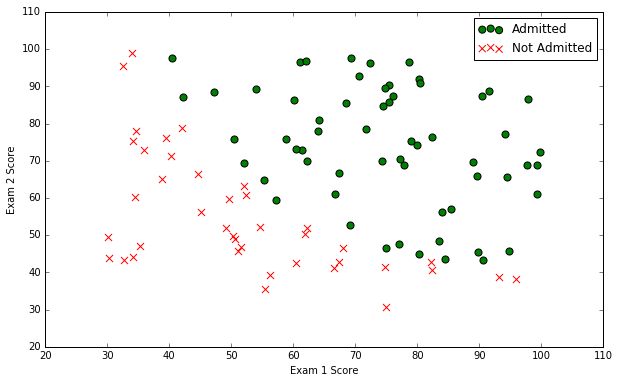

In [4]:
fig, ax = plt.subplots(figsize=(10,6))  
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='g', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

### Sigmoid and cost functions

In [5]:
def sigmoid(z):
    return 1. / (1 + np.exp(-1 * z))

# Check that it works on arrays
sigmoid(np.array([[-3, 40], [5, 0.6]]))

array([[ 0.04742587,  1.        ],
       [ 0.99330715,  0.64565631]])

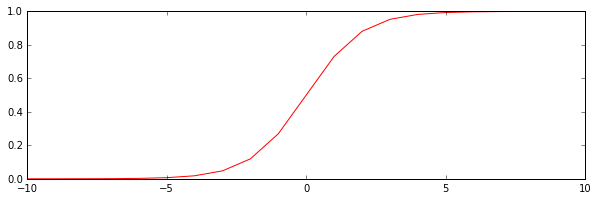

In [6]:
nums = np.arange(-10, 10)
fig, ax = plt.subplots(figsize=(10,3))  
ax.plot(nums, sigmoid(nums), c='r')

In [16]:
def prepareData(data):
    if not 'Ones' in data:
        data.insert(0, 'Ones', 1)
    
    cols = data.shape[1]
    X = np.matrix(data.iloc[:,0:cols-1].values)
    y = np.matrix(data.iloc[:,cols-1:cols].values)
    return X, y

def cost(X, y, theta):
    h_x = sigmoid(X * theta.T)
    term1 = -y.T * (np.log(h_x))
    term2 = (1 - y).T * (np.log(1 - h_x))
    return (term1 - term2)[0,0] / len(X)

theta = np.matrix(np.zeros(3))
X, y = prepareData(data)
print('Theta = {} => cost = {}'.format(theta, cost(X, y, theta)))

Theta = [[ 0.  0.  0.]] => cost = 0.6931471805599453


### Gradient descent

Note: When using Octave, the function "fminunc" is used to optimize the parameters given functions to compute the cost and the gradients. In Python, we can use SciPy's optimization API to do the same thing. Therefore, the "gradient" function only computes the adjustment to theta for **1 step** of gradient descent.

In [13]:
def gradient(X, y, theta):
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / X.shape[0]

    return grad

In [21]:
import scipy.optimize as opt

# Write some wrappers to match formats used by the scipy.optimize function
cost_bis = lambda theta, X, y: cost(X, y, np.matrix(theta))
gradient_bis = lambda theta, X, y: gradient(X, y, np.matrix(theta))

result = opt.fmin_tnc(func=cost_bis, x0=np.zeros(3), fprime=gradient_bis, args=(X, y))
final_theta = np.matrix(result[0])
print('Final cost:', cost(X, y, final_theta))

Final cost: 0.203497701589


### Predictions

In [24]:
def predict(X, theta, threshold=0.5):
    probabilities = sigmoid(X * theta.T)
    return [1 if p > threshold else 0 for p in probabilities]

In [25]:
predictions = predict(X, final_theta)

### Evaluation

In [30]:
# Accuracy
correct = [1 if a == b else 0 for a,b in zip(predictions, y)]
acc = sum(correct) / len(correct) * 100
print('Accuracy = {}%'.format(acc))

Accuracy = 89.0%


Note: This is training set accuracy... not really a valid stat!

## Regularised Logistic Regression

Regularisation is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients). The theory is that this helps to minimize overfitting and improve the model's ability to generalize. 

118 training examples: 58 positive, 60 negative


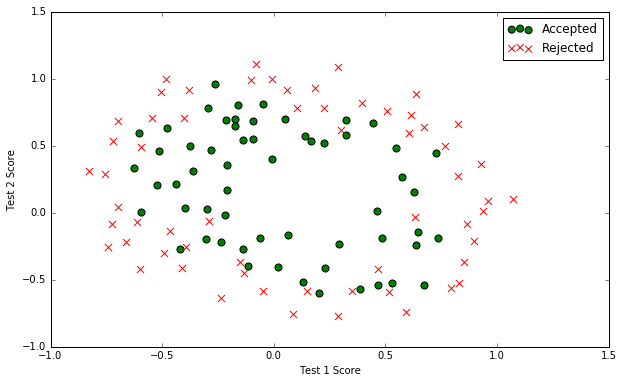

In [56]:
# data: quality tests on microchips resulting in them being accepted or not

path = ex_dir(2) + '/ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])  
positive = data2[(data2['Accepted'] == 1)]
negative = data2[(data2['Accepted'] == 0)]
print('{} training examples: {} positive, {} negative'.format(
        len(data2), len(positive), len(negative)))

fig, ax = plt.subplots(figsize=(10,6))  
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='g', marker='o', label='Accepted')  
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')  
ax.legend()  
ax.set_xlabel('Test 1 Score')  
ax.set_ylabel('Test 2 Score')  

Observation from plot: No linear boundary => polynomial features required

### Additional features: polynomial terms

In [58]:
degree = 5
x1, x2 = data2['Test 1'], data2['Test 2']
if not 'Ones' in data2:
    data2.insert(0, 'Ones', 1)

# Add polynomial terms
for i in range(degree):
    for j in range(i):
        feature_label1 = 'p{}{}'.format(i-j, j)
        if feature_label1 not in data2:
            data2[feature_label1] = np.power(x1, i-j) * np.power(x2, j)
        
        feature_label2 = 'p{}{}'.format(j, i-j)
        if feature_label2 not in data2:
            data2[feature_label2] = np.power(x1, j) * np.power(x2, i-j)

# Remove original columns
data2.drop('Test 1', axis=1, inplace=True)  
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Ones,Accepted,p10,p01,p20,p02,p11,p30,p03,p21,p12,p40,p04,p31,p13,p22
0,1,1,0.051267,0.69956,0.002628,0.489384,0.035864,0.000135,0.342354,0.001839,0.025089,0.000007,0.239497,0.000094,0.017551,0.001286
1,1,1,-0.092742,0.68494,0.008601,0.469143,-0.063523,-0.000798,0.321335,0.005891,-0.043509,0.000074,0.220095,-0.000546,-0.029801,0.004035
2,1,1,-0.213710,0.69225,0.045672,0.479210,-0.147941,-0.009761,0.331733,0.031616,-0.102412,0.002086,0.229642,-0.006757,-0.070895,0.021886
3,1,1,-0.375000,0.50219,0.140625,0.252195,-0.188321,-0.052734,0.126650,0.070620,-0.094573,0.019775,0.063602,-0.026483,-0.047494,0.035465
4,1,1,-0.513250,0.46564,0.263426,0.216821,-0.238990,-0.135203,0.100960,0.122661,-0.111283,0.069393,0.047011,-0.062956,-0.051818,0.057116


### Cost and gradient descent

In [61]:
def cost(X, y, theta, learning_rate):
    h_x = sigmoid(X * theta.T)
    term1 = -y.T * (np.log(h_x))
    term2 = (1 - y).T * (np.log(1 - h_x))
    # Note: don't forget to remove theta for intercept term
    reg = learning_rate / (2*m) * np.sum(np.power(theta[:, 1:], 2))
    return (term1 - term2)[0,0] / len(X) + reg

def gradient(X, y, theta, learning_rate):
    print('theta.shape', theta.shape)
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / X.shape[0]
        if i != 0:
            grad[i] += learning_rate / X.shape[0] * theta[i]

    return grad